# Dataset Exploration

This notebook analyzes the running pattern dataset to understand:
1. **Class distribution** - Are labels balanced?
2. **Runner distribution** - Is any runner over-represented?
3. **Camera distribution** - Are camera angles balanced?
4. **Cross-correlations** - Is a specific class only from one camera/runner?

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import our stats module
from rpa.dataset_stats import compute_dataset_stats, parse_filename

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

In [3]:
# Load dataset
DATASET_DIR = Path("/Users/nirgofman/Desktop/running-pattern/final_dataset")
stats = compute_dataset_stats(DATASET_DIR)

print(f"Total files: {stats.total_files}")
print(f"Parsed: {stats.parsed_files}")
print(f"Failed: {len(stats.failed_files)}")
print(f"\nUnique runners: {len(stats.unique_runners)}")
print(f"Unique labels: {stats.unique_labels}")
print(f"Unique cameras: {stats.unique_cameras}")

Total files: 3022
Parsed: 3022
Failed: 0

Unique runners: 17
Unique labels: [0, 1, 2]
Unique cameras: ['CAM1', 'CAM2', 'CAM3']


In [4]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame([
    {
        'runner': m.runner_id,
        'run': m.run_number,
        'camera': m.camera,
        'lap': m.lap,
        'cut': m.cut,
        'label': m.label,
        'path': str(m.path)
    }
    for m in stats.metadata
])

df.head(10)

,runner,run,camera,lap,cut,label,path
0,04HN,2,CAM1,6,1,1,/Users/nirgofman/Desktop/running-pattern/final...
1,04HN,2,CAM1,6,2,1,/Users/nirgofman/Desktop/running-pattern/final...
2,04HN,2,CAM1,6,3,1,/Users/nirgofman/Desktop/running-pattern/final...
3,04HN,2,CAM1,6,4,1,/Users/nirgofman/Desktop/running-pattern/final...
4,04HN,2,CAM1,6,5,1,/Users/nirgofman/Desktop/running-pattern/final...
5,04HN,2,CAM1,6,6,1,/Users/nirgofman/Desktop/running-pattern/final...
6,04HN,2,CAM1,6,7,1,/Users/nirgofman/Desktop/running-pattern/final...
7,04HN,2,CAM1,7,1,1,/Users/nirgofman/Desktop/running-pattern/final...
8,04HN,2,CAM1,7,2,1,/Users/nirgofman/Desktop/running-pattern/final...
9,04HN,2,CAM1,7,3,1,/Users/nirgofman/Desktop/running-pattern/final...


## 1. Class Distribution (Label Imbalance)

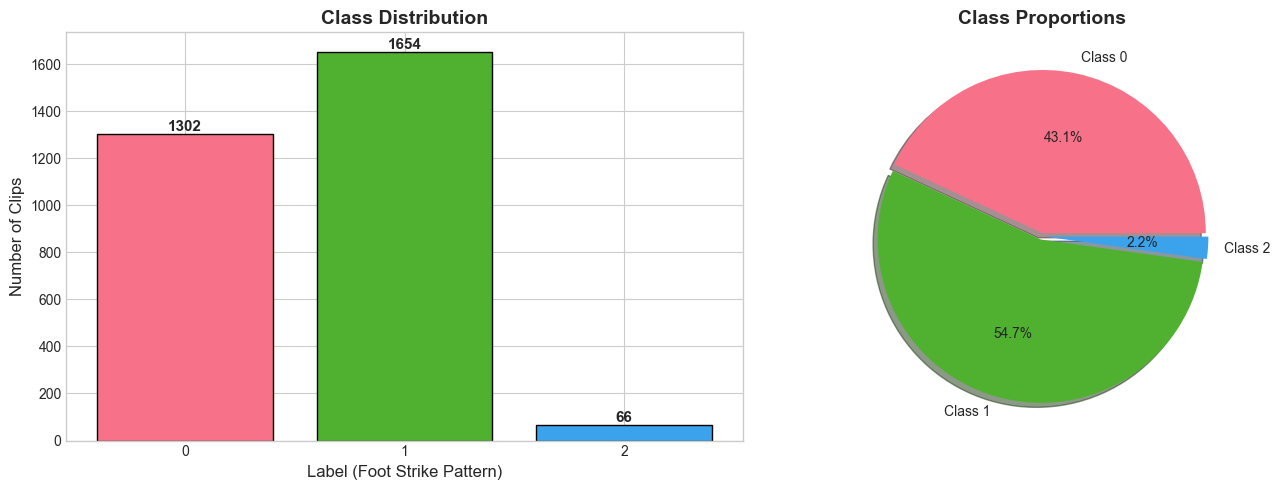


Class Imbalance Ratio: 25.06x
⚠️  WARNING: Severe class imbalance detected! Consider weighted loss or oversampling.


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
labels = sorted(stats.label_counts.keys())
counts = [stats.label_counts[l] for l in labels]
colors = sns.color_palette('husl', len(labels))

ax1 = axes[0]
bars = ax1.bar([str(l) for l in labels], counts, color=colors, edgecolor='black')
ax1.set_xlabel('Label (Foot Strike Pattern)', fontsize=12)
ax1.set_ylabel('Number of Clips', fontsize=12)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, counts):
    ax1.annotate(f'{count}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(counts, labels=[f'Class {l}' for l in labels], autopct='%1.1f%%',
        colors=colors, explode=[0.02]*len(labels), shadow=True)
ax2.set_title('Class Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print imbalance ratio
imbalance = stats.class_imbalance_ratio()
print(f"\nClass Imbalance Ratio: {imbalance:.2f}x")
if imbalance > 3:
    print("⚠️  WARNING: Severe class imbalance detected! Consider weighted loss or oversampling.")
elif imbalance > 2:
    print("⚠️  CAUTION: Moderate class imbalance. Monitor validation metrics per class.")
else:
    print("✅ Class distribution is reasonably balanced.")

## 2. Runner Distribution (Subject Imbalance)

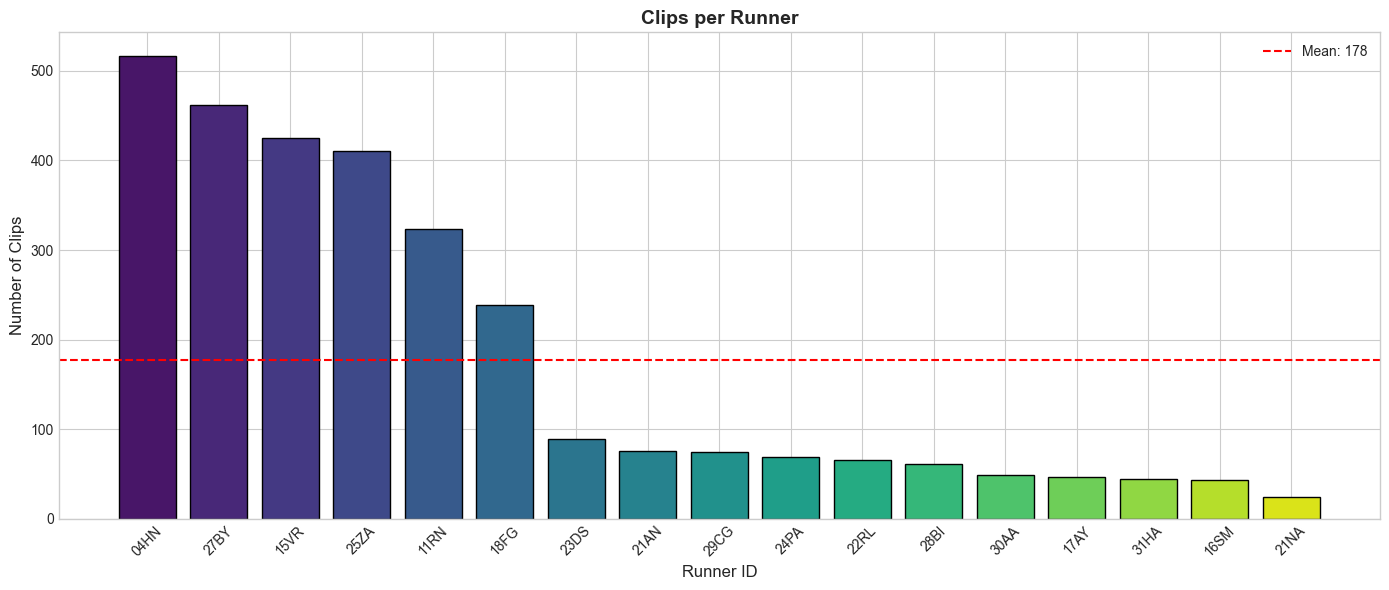


Runner count range: 24 - 517
Mean clips per runner: 177.8
Runner imbalance ratio: 21.54x


In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

runners = stats.unique_runners
runner_counts = [stats.runner_counts[r] for r in runners]

# Sort by count descending
sorted_pairs = sorted(zip(runners, runner_counts), key=lambda x: -x[1])
runners_sorted, counts_sorted = zip(*sorted_pairs)

colors = sns.color_palette('viridis', len(runners))
bars = ax.bar(runners_sorted, counts_sorted, color=colors, edgecolor='black')

ax.set_xlabel('Runner ID', fontsize=12)
ax.set_ylabel('Number of Clips', fontsize=12)
ax.set_title('Clips per Runner', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

# Add horizontal line for mean
mean_count = np.mean(counts_sorted)
ax.axhline(y=mean_count, color='red', linestyle='--', label=f'Mean: {mean_count:.0f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nRunner count range: {min(counts_sorted)} - {max(counts_sorted)}")
print(f"Mean clips per runner: {mean_count:.1f}")
print(f"Runner imbalance ratio: {stats.runner_imbalance_ratio():.2f}x")

## 3. Camera Distribution

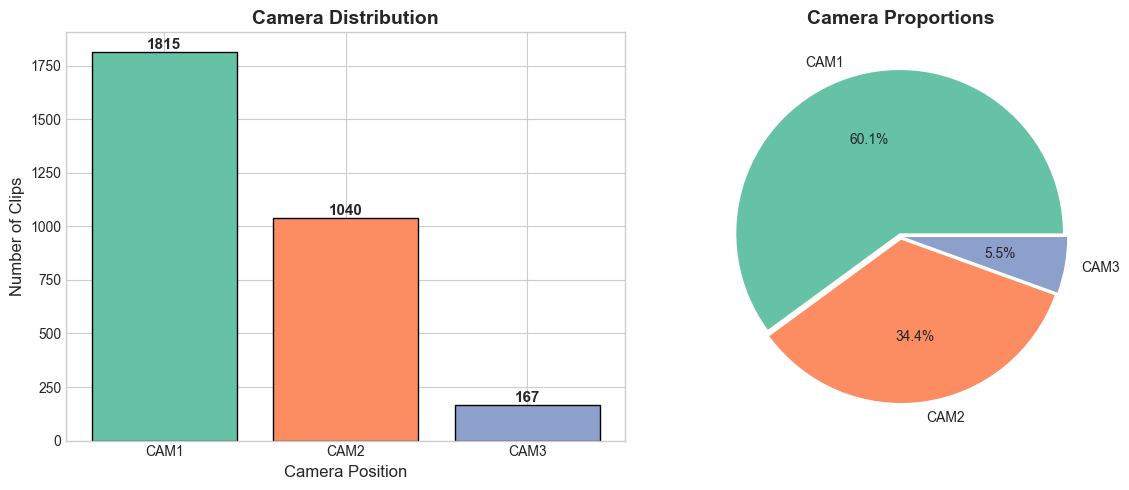

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cameras = stats.unique_cameras
cam_counts = [stats.camera_counts[c] for c in cameras]
colors = sns.color_palette('Set2', len(cameras))

# Bar chart
ax1 = axes[0]
bars = ax1.bar(cameras, cam_counts, color=colors, edgecolor='black')
ax1.set_xlabel('Camera Position', fontsize=12)
ax1.set_ylabel('Number of Clips', fontsize=12)
ax1.set_title('Camera Distribution', fontsize=14, fontweight='bold')

for bar, count in zip(bars, cam_counts):
    ax1.annotate(f'{count}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(cam_counts, labels=cameras, autopct='%1.1f%%',
        colors=colors, explode=[0.02]*len(cameras))
ax2.set_title('Camera Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Cross-Correlations (Detecting Confounds)

Check if labels are correlated with cameras or specific runners.

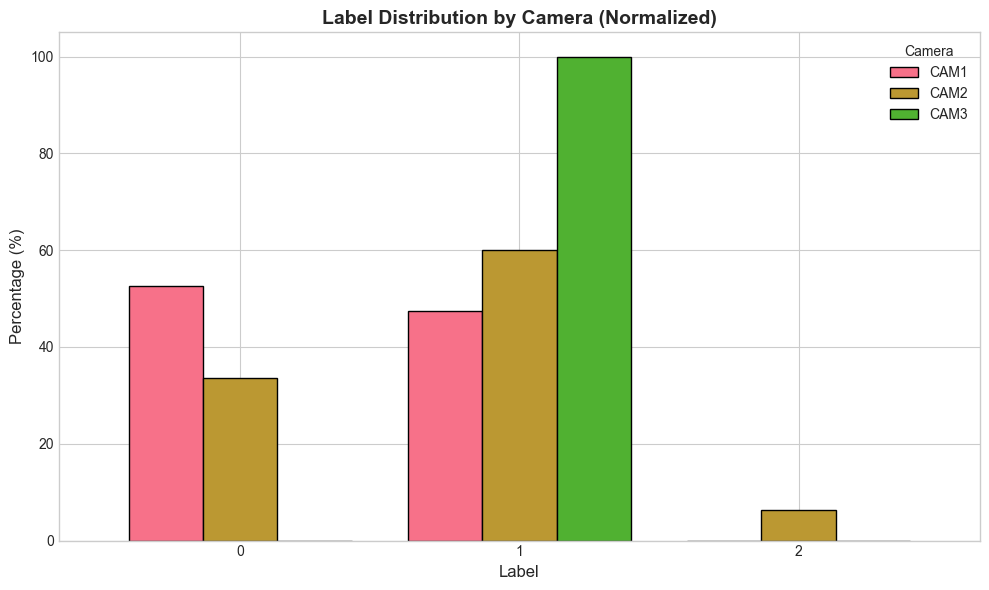

If bars are similar across cameras, labels are NOT confounded with camera angle.


In [8]:
# Label distribution by Camera
label_camera_matrix = pd.crosstab(df['label'], df['camera'], normalize='columns') * 100

fig, ax = plt.subplots(figsize=(10, 6))
label_camera_matrix.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Label Distribution by Camera (Normalized)', fontsize=14, fontweight='bold')
ax.legend(title='Camera')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("If bars are similar across cameras, labels are NOT confounded with camera angle.")

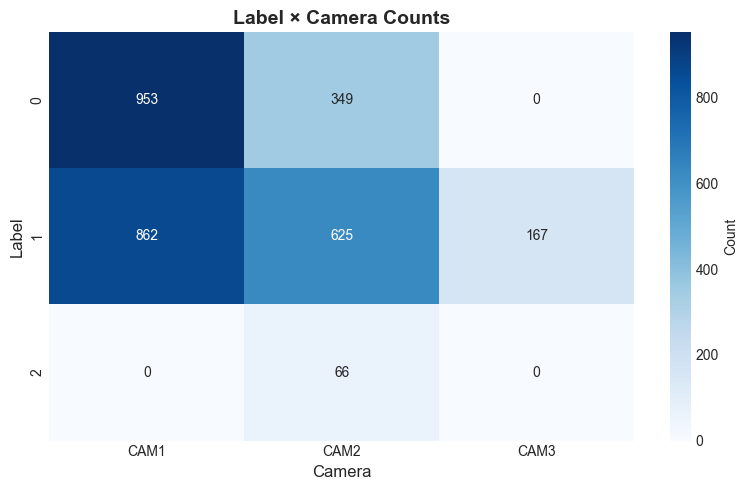

In [9]:
# Heatmap: Label x Camera
label_camera_counts = pd.crosstab(df['label'], df['camera'])

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(label_camera_counts, annot=True, fmt='d', cmap='Blues', ax=ax,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Camera', fontsize=12)
ax.set_ylabel('Label', fontsize=12)
ax.set_title('Label × Camera Counts', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

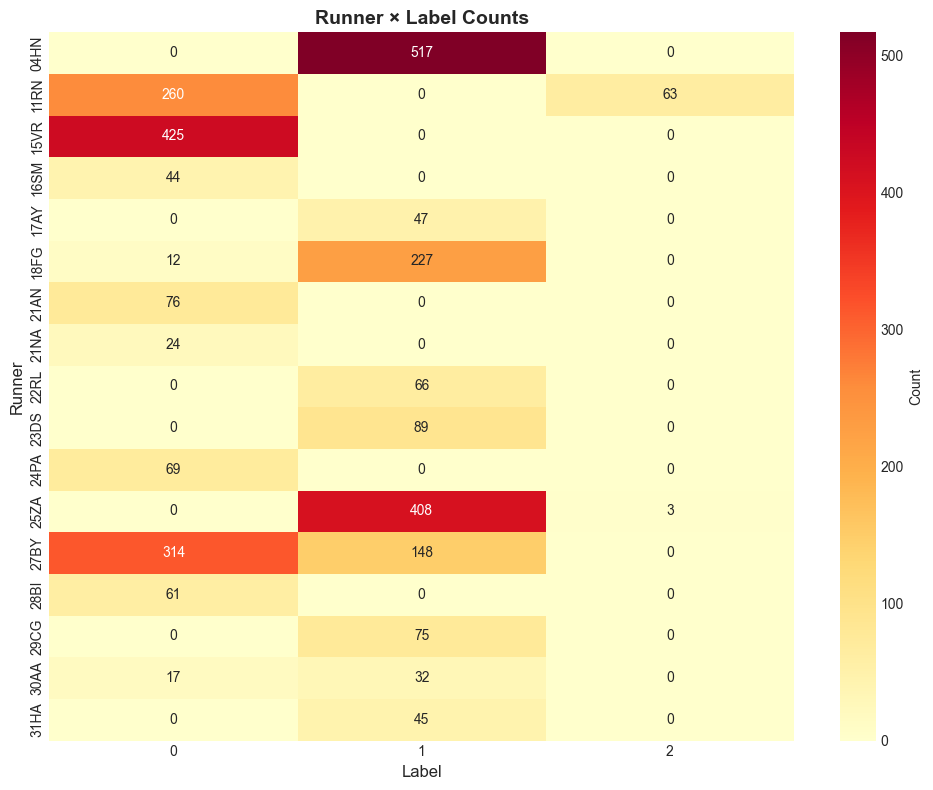


⚠️  5 runners have multiple labels:
runner
11RN    2
18FG    2
25ZA    2
27BY    2
30AA    2
dtype: int64


In [10]:
# Label distribution by Runner (heatmap)
label_runner_counts = pd.crosstab(df['runner'], df['label'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(label_runner_counts, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Runner', fontsize=12)
ax.set_title('Runner × Label Counts', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check: each runner should ideally have only ONE label (their foot strike pattern)
runners_with_multiple_labels = (label_runner_counts > 0).sum(axis=1)
multi_label_runners = runners_with_multiple_labels[runners_with_multiple_labels > 1]
if len(multi_label_runners) > 0:
    print(f"\n⚠️  {len(multi_label_runners)} runners have multiple labels:")
    print(multi_label_runners)
else:
    print("\n✅ Each runner has a single consistent label.")

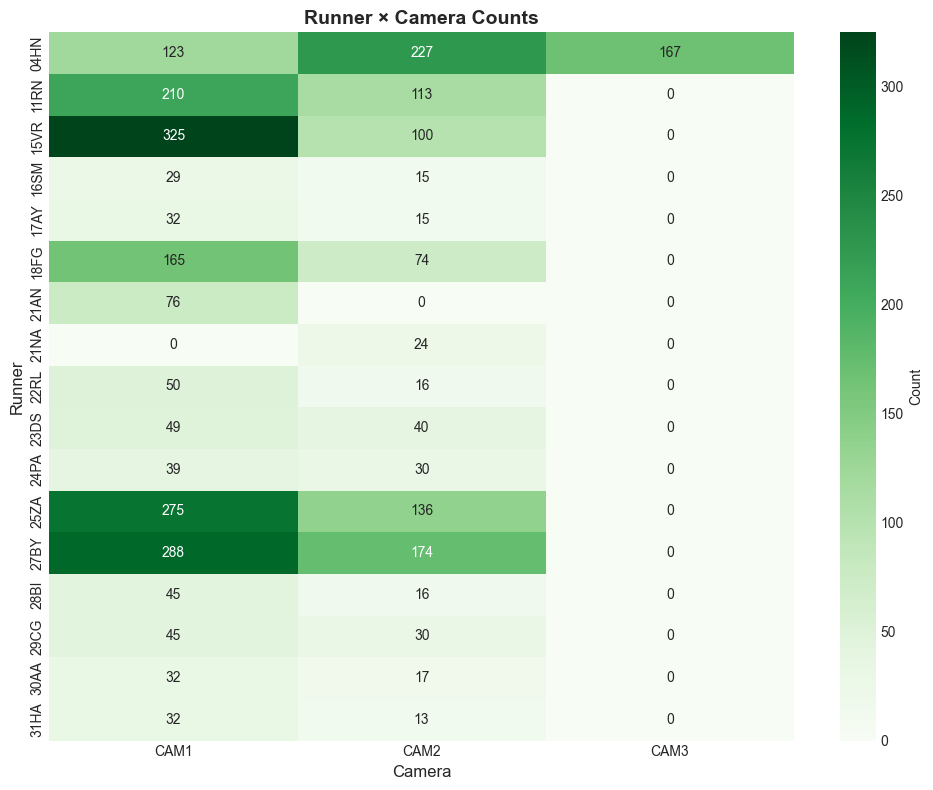

In [11]:
# Camera distribution by Runner
camera_runner_counts = pd.crosstab(df['runner'], df['camera'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(camera_runner_counts, annot=True, fmt='d', cmap='Greens', ax=ax,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Camera', fontsize=12)
ax.set_ylabel('Runner', fontsize=12)
ax.set_title('Runner × Camera Counts', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Summary Statistics

In [12]:
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Total clips: {stats.parsed_files}")
print(f"Unique runners: {len(stats.unique_runners)}")
print(f"Unique labels: {len(stats.unique_labels)}")
print(f"Cameras: {stats.unique_cameras}")
print()
print("Class Distribution:")
for label in stats.unique_labels:
    count = stats.label_counts[label]
    pct = count / stats.parsed_files * 100
    print(f"  Label {label}: {count:5d} clips ({pct:5.1f}%)")
print()
print(f"Class imbalance ratio: {stats.class_imbalance_ratio():.2f}x")
print(f"Runner imbalance ratio: {stats.runner_imbalance_ratio():.2f}x")
print()

# Recommendations
print("=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)
if stats.class_imbalance_ratio() > 3:
    print("❌ Severe class imbalance - use weighted loss or oversampling")
elif stats.class_imbalance_ratio() > 2:
    print("⚠️  Moderate class imbalance - consider class weights")
else:
    print("✅ Class balance is acceptable")

if stats.runner_imbalance_ratio() > 5:
    print("⚠️  Large runner imbalance - ensure proper train/test split by runner")
else:
    print("✅ Runner distribution is acceptable")

print("\n💡 Remember: Split by RUNNER ID, not randomly!")

DATASET SUMMARY
Total clips: 3022
Unique runners: 17
Unique labels: 3
Cameras: ['CAM1', 'CAM2', 'CAM3']

Class Distribution:
  Label 0:  1302 clips ( 43.1%)
  Label 1:  1654 clips ( 54.7%)
  Label 2:    66 clips (  2.2%)

Class imbalance ratio: 25.06x
Runner imbalance ratio: 21.54x

RECOMMENDATIONS
❌ Severe class imbalance - use weighted loss or oversampling
⚠️  Large runner imbalance - ensure proper train/test split by runner

💡 Remember: Split by RUNNER ID, not randomly!
